In [1]:
from astro_constants import *
from source_parameters import *
from rates import *

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.integrate import quad
from astropy import units as u
from astropy import constants as const
from scipy.stats import chisquare
from scipy.optimize import curve_fit

In [3]:
## Initialize the class
coronal_data = Coronal_Description(r_x, l, l_x, mdot, m)

## Calculate parameters for emission region
B_c = coronal_data.coronal_mag_field()
n_c = coronal_data.coronal_density()
T_c = coronal_data.coronal_temperature()
delta_RX = coronal_data.width_current_sheet()
wdot_B = coronal_data.mag_rec_power()

print(f'\nCoronal Magnetic Field:\n B_c = {B_c:.4E} G')
print(f'\nCoronal Particle Number Density:\n n_c = {n_c:.4E} cm-3')
print(f'\nCoronal Temperature:\n T_c = {T_c:.4E} K')
print(f'\nWidth of the current sheet:\n delta_RX = {delta_RX:.4E} cm')
print(f'\nReconnection Power:\n wdot_B = {wdot_B:.4E} erg s-1')


Coronal Magnetic Field:
 B_c = 1.0478E+04 G

Coronal Particle Number Density:
 n_c = 3.4392E+10 cm-3

Coronal Temperature:
 T_c = 2.5282E+09 K

Width of the current sheet:
 delta_RX = 1.6649E+11 cm

Reconnection Power:
 wdot_B = 5.9912E+42 erg s-1


In [4]:
Ep = np.linspace(1e2, 1e20) * eV # Energy range [erg]
Ee = np.linspace(1e2, 1e15) * eV
Ep_drift = np.linspace(5.23e17, 1e20) * eV
Ee_drift = np.linspace(5.23e17, 1e15) * eV

rho = n_c * mp # [g cm-3] fluid density

In [5]:
v_a0 = B_c / np.sqrt(4 * np.pi * rho)

va = v_a0 * coronal_data.Gamma

va/c

0.29069046222286127

In [6]:
eV / mpc2

1.0657890249309368e-09

Trying to integrate photon density

In [7]:
r_c = 10 * R_s  # [cm] coronal size
L_x = 7 * 10**43 # [erg s-1]
epsilon_0 = 7 * keV # [erg] 7 keV = 7e3 * erg to eV compton hump energy

U_x = L_x / (4 * np.pi * c * r_c**2)

In [8]:
n_x = U_x * ( epsilon_0**(-2) * (20*keV - 1*keV) + ( -(200*keV)**(-1) + (20*keV)**(-1) ) )

In [9]:
print(f'\nPhoton field Energy Density for X-rays = {n_x:.5E} cm-3')


Photon field Energy Density for X-rays = 1.43205E+13 cm-3


In [10]:
def n_ph(eps):
    """Isotropic photon field density.
    Eq. (4) from Mbarek et al. 2023."""
    r_c = 10 * R_s  # [cm] coronal size
    L_x = 7 * 10**43  # [erg s^-1]
    epsilon_0 = 7 * keV  # [erg] (compton hump energy)
    
    U_x = L_x / (4 * np.pi * c * r_c**2)  # [erg cm^-3]
    
    dnxde = np.zeros_like(eps)  # Initialize the array to store the results
    
    for i in range(len(eps)):
        if eps[i] < (20 * keV):
            dnxde[i] = U_x * epsilon_0**(-2)
        elif (20 * keV) <= eps[i] <= (200 * keV):
            dnxde[i] = U_x * eps[i]**(-2)
        else:
            0.
            # dnxde[i] = 1.43205e13/eps[i]
    
    return dnxde


In [11]:
# ## X-rays
# def n_ph(eps):
#     """Isotropic photon field density.
#     Eq. (4) from Mbarek et al. 2023."""
#     r_c = 10 * R_s  # [cm] coronal size
#     L_x = 7 * 10**43  # [erg s^-1]
#     epsilon_0 = 7*keV  # [erg] (compton hump energy)
    
#     U_x = L_x / (4 * np.pi * c * r_c**2)  # [erg cm^-3]
#     # n_x = U_x * ( epsilon_0**(-2) * (20*keV - 1*keV) + ( -(200*keV)**(-1) + (20*keV)**(-1) ) )
#     # print(f'\nPhoton field Energy Density for X-rays = {n_x:.5E} cm^-3')
#     # [cm-3]
    
#     if eps < (20*keV):
#         dnxde = U_x * epsilon_0**(-2)
#     elif (20*keV) <= eps <= (200*keV):
#         dnxde = U_x * eps**(-2)
#     else:
#         dnxde = 0.
    
#     return dnxde




# def Uphf(eps,nph):
#     deps = np.diff(eps)
#     val=0.
#     for i in range(len(deps)):
#         val = val + nph[i] * eps[i] *deps[i]
#     return val




# def nph_bb(eps,T): 
#     '''  erg^-1 cm^-3  '''
#     return np.pi / (c*h*eps) * Bnu(eps,T)




# def rate_pg(Ep, eps, nph):
    
#     Eth_pg = 145 * 1e6 * eV
#     k1 = 0.2
#     s1 = 340 * 1e-6 * barn
#     k2 = 0.6
#     s2 = 120 * 1e-6 * barn
#     C1 = -.5*k1*s1*(200*MeV)**2
#     C2 = -.5*k2*s2*(500*MeV)**2 + .5*k1*s1*(500*MeV)**2 - .5*k1*s1*(200*MeV)**2
    
#     def II(eps,Ep):
        
#         if( (2*eps*Ep /mpc2) < (200*MeV) ):
#             return 0.
        
#         elif( ( (200*MeV)<=(2*eps*Ep /mpc2) ) & ( (2*eps*Ep /mpc2)<(500*MeV) ) ):
#             return k1*s1/2 *(2*eps*Ep/mpc2)**2 + C1
        
#         elif( (2*eps*Ep/mpc2) > 500*MeV ):
#             return k2*s2/2 *(2*eps*Ep/mpc2)**2 + C2
    
#     SSum = np.zeros(np.size(Ep))
#     deps = np.diff(eps)

#     for j in range(np.size(Ep)):
#         for i in range(np.size(deps)):
#             if(eps[i] > (Eth_pg * mpc2 / 2 / Ep[j]) ):
#                 SSum[j] = SSum[j] + mp**2 * c**5 / 2 / Ep[j]**2 * deps[i] * nph[i] / eps[i]**2 * II(eps[i], Ep[j])                    
#     return  SSum

In [12]:
eps_th = 0.15 * GeV  # [erg]

def rate_pgamma_cool(Ep, eps, nph):
    """
    Cooling rate [s^-1] of protons of energy Ep due to the photo-pion process.
    Arguments:
    Ep  : [erg] energy of protons (vector).
    eps : [erg] energy of the target photons (vector).
    nph : [cm-3 erg-1] number density of photons at the energy eps (vector).
    """
    gamma_p = Ep / mpc2  # Lorentz factor of the protons
    Ieps = np.zeros_like(gamma_p)  # Array to store the integral results for each proton energy

    sigma1 = 340 * 1e-6 * barn  # [microbarn in cm^2]
    K1 = 0.2
    sigma2 = 120 * 1e-6 * barn  # [microbarn in cm^2]
    K2 = 0.6

    def fI(eps, gamma_p):
        x = 2 * eps * gamma_p  # Higher limit of the inside integral
        def I1(x):
            return sigma1 * K1 * 0.5 * x**2
        def I2(x):
            return sigma2 * K2 * 0.5 * x**2

        if x < 200 * MeV:
            return 0.
        elif 200 * MeV <= x < 500 * MeV:
            return I1(x) - I1(200 * MeV)
        else:  # x >= 500 * MeV
            return I1(500 * MeV) - I1(200 * MeV) + I2(x) - I2(500 * MeV)
    
    for i in range(len(gamma_p)):
        eps_inf = eps_th / (2 * gamma_p[i])  # Lower limit of outer integral

        if eps[0] <= eps_inf < eps[-1]:
            # Start index ensuring it starts from the next higher bin
            j0 = np.searchsorted(eps, eps_inf)
            
            for j in range(j0, len(eps) - 1):
                Ieps[i] += (eps[j+1] - eps[j]) * nph[j] / (eps[j]**2) * fI(eps[j], gamma_p[i])
    
    return c / (2 * gamma_p**2) * Ieps

eps = np.linspace(1, 1e15) * keV  # Photon energy range [erg]
# Ep = np.linspace(1e9, 1e15) * eV  # Energy range [erg]
nph = n_ph(eps)  # Photon field density

cooling_rate = rate_pgamma_cool(Ep, eps, nph)
print(cooling_rate)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


In [13]:
2500 * 12398

30995000

In [14]:
## OUV
r_OUV = 100 * R_s  # OUV radius [cm]

# Parameters for the OUV photon field
eps_min = 1050 * 12398 * eV # [erg] 1 angstrom = 12398 eV - Lower energy limit
eps_max = 2500 * 12398 * eV # [erg] Upper energy limit 

# Energy density U_OUV
L_2keV = 7e43  # Luminosity at 2 keV [erg/s] (Lx)
log_L_2500A = (1 / 0.760) * (np.log10(L_2keV) - 3.508)
L_2500A = 10**log_L_2500A  # Luminosity at 2500 Angstroms [erg/s]
U_OUV = L_2500A / (4 * np.pi * c * r_OUV**2)  # Energy density [erg/cm^3]

# Photo-pion interaction parameters
sigma_pg = 340 * 1e-6 * barn  # Cross-section for p-gamma interaction [cm^2]
K_pg = 0.2  # Inelasticity

# Threshold photon energy
eps_th = 0.15 * GeV  # [erg]

def n_OUV(eps):
    """Isotropic OUV photon field density."""
    if eps_min <= eps <= eps_max:
        return U_OUV * eps**(-1)
    else:
        return 0.

# Cooling rate function
def rate_pgamma_OUV(Ep):
    """
    Cooling rate [s^-1] of protons due to the photo-pion process in the OUV photon field.
    Arguments:
    Ep  : [erg] energy of protons (vector).
    """
    gamma_p = Ep / mpc2  # Lorentz factor of the protons
    gamma_c = eps_th / (2 * eps_min)  # Critical Lorentz factor

    # Define photon energy range for integration
    eps = np.linspace(eps_min, eps_max, num=1000)  # Photon energy range [erg]
    
    # Initialize the cooling rate array
    t_pg_inv = np.zeros_like(gamma_p)
    
    # Integrate over the photon energy range
    for i in range(len(gamma_p)):
        integrand = np.array([n_OUV(e) * (np.log(gamma_p[i] / (eps_th / (2 * e))) + (eps_th / (2 * e))**2 / (2 * gamma_p[i]**2) - 0.5) 
                              for e in eps])
        t_pg_inv[i] = c * K_pg * sigma_pg * np.trapz(integrand, eps)
    
    return t_pg_inv

# Calculate the cooling rate
cooling_rate_OUV = rate_pgamma_OUV(Ep)

# Print or plot the cooling rate
print(cooling_rate_OUV)

[1.10443369e+09 3.13432452e-05 3.24470186e-05 3.30926847e-05
 3.35507920e-05 3.39061277e-05 3.41964581e-05 3.44419289e-05
 3.46545654e-05 3.48421241e-05 3.50099011e-05 3.51616738e-05
 3.53002315e-05 3.54276922e-05 3.55457023e-05 3.56555672e-05
 3.57583389e-05 3.58548780e-05 3.59458976e-05 3.60319946e-05
 3.61136745e-05 3.61913684e-05 3.62654473e-05 3.63362326e-05
 3.64040049e-05 3.64690102e-05 3.65314656e-05 3.65915636e-05
 3.66494758e-05 3.67053555e-05 3.67593406e-05 3.68115554e-05
 3.68621123e-05 3.69111133e-05 3.69586514e-05 3.70048114e-05
 3.70496710e-05 3.70933013e-05 3.71357681e-05 3.71771316e-05
 3.72174479e-05 3.72567687e-05 3.72951418e-05 3.73326120e-05
 3.73692207e-05 3.74050066e-05 3.74400060e-05 3.74742527e-05
 3.75077783e-05 3.75406127e-05]


In [15]:
# sigma1 = 340 * 1e-6 * barn  # Cross-section for Bethe-Heitler process [cm^2]
# bar_eps_bth = 2 * MeV  # Threshold photon energy for Bethe-Heitler process [erg]


# def sigma_pgamma_bth(eps_prime):
#     """Bethe-Heitler cross-section."""
#     return sigma1  # Simplified cross-section model [cm^2]

# def n_OUV2(eps):
#     """Isotropic OUV photon field density."""
#     r_OUV = 100 * R_s  # [cm]
#     eps_min = 4.95937 * eV  # Lower energy limit [erg]
#     eps_max = 11.808023 * eV  # Upper energy limit [erg]
    
#     # Energy density U_OUV
#     L_2keV = 7e43  # Luminosity at 2 keV [erg/s]
#     log_L_2500A = (1 / 0.760) * (np.log10(L_2keV) - 3.508)
#     L_2500A = 10**log_L_2500A  # Luminosity at 2500 Angstroms [erg/s]
#     U_OUV = L_2500A / (4 * np.pi * c * r_OUV**2)  # Energy density [erg/cm^3]
    
#     dnxde = np.zeros_like(eps)  # Initialize the array to store the results
#     dnxde[(eps >= eps_min) & (eps <= eps_max)] = U_OUV * eps[(eps >= eps_min) & (eps <= eps_max)]**(-1)
    
#     return dnxde

# def rate_bethe_heitler(Ep, eps, nph):
#     """
#     Cooling rate [s^-1] of protons of energy Ep due to the Bethe-Heitler process.
#     Arguments:
#     Ep  : [erg] energy of protons (vector).
#     eps : [erg] energy of the target photons (vector).
#     nph : [cm-3 erg-1] number density of photons at the energy eps (vector).
#     """
#     gamma_p = Ep / mpc2  # Lorentz factor of the protons
#     t_bth_inv = np.zeros_like(gamma_p)  # Array to store the cooling rate results

#     for i in range(len(gamma_p)):
#         eps_inf = bar_eps_bth / (2 * gamma_p[i])  # Lower limit of the outer integral
#         eps_inf = max(eps_inf, eps[0])  # Ensure eps_inf is within bounds

#         # Find indices for the range of photon energies
#         j0 = np.searchsorted(eps, eps_inf)
#         if j0 >= len(eps):
#             j0 = len(eps) - 1

#         integral_outer = 0.0
#         for j in range(j0, len(eps) - 1):
#             # Inner integral
#             eps_prime_min = bar_eps_bth
#             eps_prime_max = 2 * gamma_p[i] * eps[j]
#             k0 = np.searchsorted(eps, eps_prime_min)
#             k1 = np.searchsorted(eps, eps_prime_max, side='right')
#             k1 = min(k1, len(eps))  # Ensure k1 is within bounds

#             integral_inner = 0.0
#             for k in range(k0, k1):
#                 if k + 1 < len(eps):
#                     integral_inner += (eps[k+1] - eps[k]) * sigma_pgamma_bth(eps[k]) * eps[k]
            
#             # Outer integral contribution
#             if j + 1 < len(eps):
#                 integral_outer += (eps[j+1] - eps[j]) * nph[j] / (eps[j]**2) * integral_inner

#         t_bth_inv[i] = c / (gamma_p[i]**2) * integral_outer

#     return t_bth_inv

# # Example parameters
# eps = np.linspace(1, 1e9, num=1000) * keV  # Photon energy range [erg]
# Ep = np.logspace(9, 1e20, num=100) * eV  # Proton energy range [erg]
# nph_isotropic = n_ph(eps)  # Photon field density for isotropic
# nph_ou = n_OUV2(eps)  # Photon field density for OUV

# # Calculate cooling rates
# cooling_rate_bth_isotropic = rate_bethe_heitler(Ep, eps, nph_isotropic)
# cooling_rate_bth_ou = rate_bethe_heitler(Ep, eps, nph_ou)

# # Print or plot the cooling rates
# print("Cooling rate with isotropic photon field:")
# print(cooling_rate_bth_isotropic)

# print("Cooling rate with OUV photon field:")
# print(cooling_rate_bth_ou)


In [16]:
# def timeacc_fermi(E):
#     '''Eq.(2.37) of Medina-Torrejon Thesis'''
#     alpha = 0.1
#     s = 1/alpha
#     E0 = 10**(4)
#     t0 = 700
#     ## hours
#     return s**(-1) * (E0/E)**(-1/s) * t0
#     # return (E0/E)**(-1/s) * t0


def time_acc_regime3(va, delta_RX):
    v_in = 0.05 * va
    beta_in = v_in / c
    d_ur = 2 * beta_in * ( 3 * beta_in**2 + 3*beta_in + 1 ) / ( 3 * (beta_in + 0.5) * (1 - beta_in**2) )
    
    return 4 * delta_RX / (c * d_ur)


def timeacc_drift(E, B, va):
    '''Eq.(7) of Del Valle, de Gouveia Dal Pino & Kowal 2016 e de Gouveia Dal Pino & Kowal 2015'''
    v_rec = 0.05 * va
    
    return E / (qe*B*v_rec)

In [22]:
time_acc_regime3(va, delta_RX)

1129.4022114212746

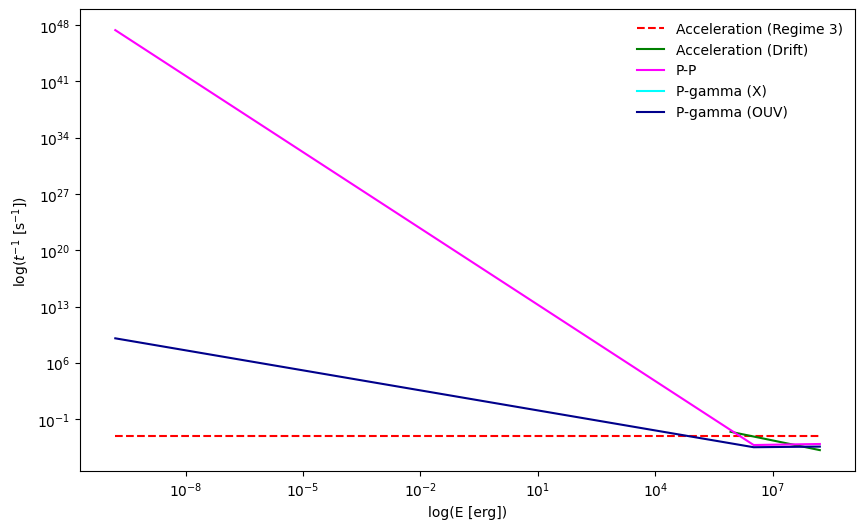

In [25]:
## erg

plt.figure(figsize=(10, 6))

# plt.loglog(Ee,1/tacc_fermi(Ee),'--',label='Acceleration (Fermi)',color='blue')
# plt.loglog(Ee,1/tacc_drift(Ee, B_c, va),label='Acceleration (Drift)',color='purple')
plt.loglog(Ep,[1/time_acc_regime3(va, delta_RX)]*len(Ep),'--',label='Acceleration (Regime 3)',color='red')
plt.loglog(Ep_drift,1/timeacc_drift(Ep_drift, B_c, va),label='Acceleration (Drift)',color='green')
# plt.loglog(Ep,tacc_shock(B_c, Ep),label='Acceleration (Shock)',color='r')
plt.loglog(Ep,t_pp(n_c, Ep),label='P-P',color='magenta')
plt.loglog(Ep,cooling_rate,label='P-gamma (X)',color='cyan')
plt.loglog(Ep,cooling_rate_OUV,label='P-gamma (OUV)',color='darkblue')
# plt.loglog(Ep,cooling_rate_bth_isotropic,label='B-H (X)',color='orange')
# plt.loglog(Ep,cooling_rate_bth_ou,label='B-H (OUV)',color='purple')

# plt.xlim((Ep.min(),Ep.max()))
plt.legend(frameon=False)
plt.xlabel('log(E [erg])')
plt.ylabel('log($t^{-1}$ [s$^{-1}$])')
# plt.ylim((1e-4,1e4))
# plt.xticks([1e-2,1e-1,1e0,1e1,1e2,1e3],labels=['-2','-1','0','1','2','3'])
plt.savefig('plots/cooling_hadrons_erg.png',dpi=300)

plt.show()

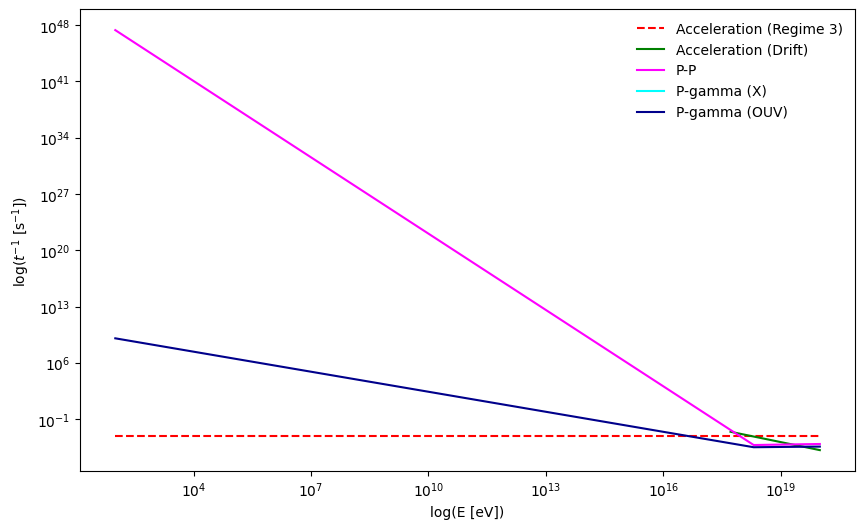

In [26]:
## eV

plt.figure(figsize=(10, 6))

# plt.loglog(Ee/erg,1/tacc_fermi(Ee),'--',label='Acceleration (Fermi)',color='blue')
# plt.loglog(Ee/erg,1/tacc_drift(Ee, B_c, va),label='Acceleration (Drift)',color='purple')
plt.loglog(Ep/eV,[1/time_acc_regime3(va, delta_RX)]*len(Ep),'--',label='Acceleration (Regime 3)',color='red')
plt.loglog(Ep_drift/eV,1/timeacc_drift(Ep_drift, B_c, va),label='Acceleration (Drift)',color='green')
# plt.loglog(Ep/eV,tacc_p_rec(Ep, l_x, B_c, rho),'--',label='Acceleration (Reconnection)',color='k')
# plt.loglog(Ep/eV,tacc_shock(B_c, Ep),label='Acceleration (Shock)',color='r')
plt.loglog(Ep/eV,t_pp(n_c, Ep),label='P-P',color='magenta')
plt.loglog(Ep/eV,cooling_rate,label='P-gamma (X)',color='cyan')
plt.loglog(Ep/eV,cooling_rate_OUV,label='P-gamma (OUV)',color='darkblue')
# plt.loglog(Ep/eV,cooling_rate_bth_isotropic,label='B-H (X)',color='orange')
# plt.loglog(Ep/eV,cooling_rate_bth_ou,label='B-H (OUV)',color='purple')

# plt.xlim((1e9,Ep.max()/eV))
plt.legend(frameon=False,loc='upper right')
plt.xlabel('log(E [eV])')
plt.ylabel('log($t^{-1}$ [s$^{-1}$])')
# plt.ylim((1e-11,1e9))
# plt.xticks([1e9,1e10,1e11,1e12,1e13,1e14,1e15],labels=['9','10','11','12','13','14','15'])

plt.savefig('plots/cooling_hadrons_eV.png',dpi=300)

plt.show()

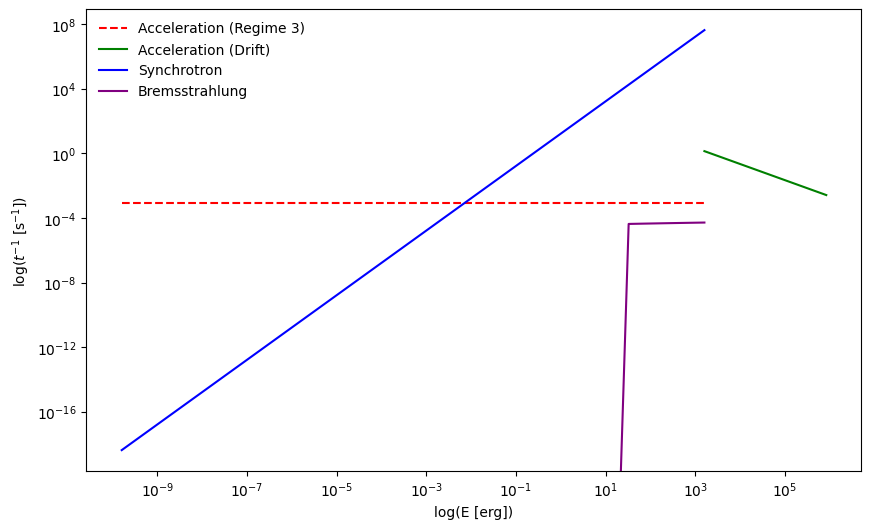

In [27]:
## Leptons


## erg

plt.figure(figsize=(10, 6))
# plt.loglog(Ee,tacc_e_rec(Ee, l_x, B_c, rho),'--',label='Acceleration (Reconnection)',color='k')
plt.loglog(Ee,[1/time_acc_regime3(va, delta_RX)]*len(Ee),'--',label='Acceleration (Regime 3)',color='red')
plt.loglog(Ee_drift,1/timeacc_drift(Ee_drift, B_c, va),label='Acceleration (Drift)',color='green')
# plt.loglog(Ee,tacc_shock(B_c, Ee),label='Acceleration (Shock)',color='r')
plt.loglog(Ee,tloss_syn(Ee, B_c, me),label='Synchrotron',color='blue')
plt.loglog(Ee,tloss_bre(n_c, 1, Ee),label='Bremsstrahlung',color='purple')

# plt.xlim((Ee.min(),Ee.max()))
plt.legend(frameon=False)
plt.xlabel('log(E [erg])')
plt.ylabel('log($t^{-1}$ [s$^{-1}$])')
# plt.ylim((1e-4,1e4))
# plt.xticks([1e-2,1e-1,1e0,1e1,1e2,1e3],labels=['-2','-1','0','1','2','3'])
plt.savefig('plots/cooling_leptons_erg.png',dpi=300)

plt.show()

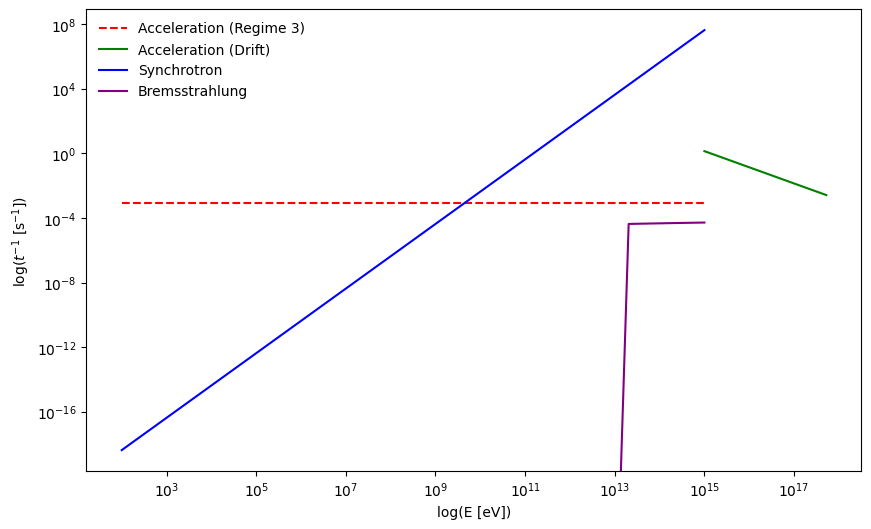

In [28]:
###### eV

plt.figure(figsize=(10, 6))

# plt.loglog(Ee/eV,tacc_e_rec(Ee, l_x, B_c, rho),'--',label='Acceleration (Reconnection)',color='k')
plt.loglog(Ee/eV,[1/time_acc_regime3(va, delta_RX)]*len(Ee),'--',label='Acceleration (Regime 3)',color='red')
plt.loglog(Ee_drift/eV,1/timeacc_drift(Ee_drift, B_c, va),label='Acceleration (Drift)',color='green')
# plt.loglog(Ee/eV,tacc_shock(B_c, Ee),label='Acceleration (Shock)',color='r')
plt.loglog(Ee/eV,tloss_syn(Ee, B_c, me),label='Synchrotron',color='blue')
plt.loglog(Ee/eV,tloss_bre(n_c, 1, Ee),label='Bremsstrahlung',color='purple')

# plt.xlim((1e9,Ee.max()/eV))
plt.legend(frameon=False)
plt.xlabel('log(E [eV])')
plt.ylabel('log($t^{-1}$ [s$^{-1}$])')
# plt.ylim((1e-11,1e9))
# plt.xticks([1e9,1e10,1e11,1e12,1e13,1e14,1e15],labels=['9','10','11','12','13','14','15'])

plt.savefig('plots/cooling_leptons_eV.png',dpi=300)

plt.show()

Maria:


Porém sempre usei o método de Simpson, com os limites de integração como funções, usando duas grades de energia. O método de quadratura pode ser uma boa opção, talvez mais fácil de aplicar para este caso. Pode ser um desafio numérico dependendo da experiência em programação, mas com paciência consegue e serve para aprender a debugar.  Se ela usa o python pode usar as rotinas prontas, se ela usa fortran pode usar rotinas prontas e testadas também, há para todos os gostos. Não precisa escrever o algoritmo.


Uma dica importante é usar uma variável logarítmica (na base 10), nas integrais que envolvem energias. Isto geralmente resolve os problemas numéricos (se for um problema numérico mesmo). 


Mas dependendo do problema, talvez não precise fazer as duas integrações. Existem expressões já integradas para os casos: campo de radiación térmico de densidad de energı́a w_ph con una energı́a media por fóton <hkT> ou no caso campo de radiación con una distribución en energı́as del tipo lei de potências (acho que pode achá las aqui Mannheim, K. & Schlickeiser, R. 1994, Astron. Astroph., 286, 983, se a Luana não acha pode me escrever). 

In [21]:
## integral usando o método de Simpson

Juan:

Para calcular o tempo de esfriamento devido à interação próton-fóton e para a maioria das integrações em processos não térmicos, o método que eu uso basicamente consiste em fazer uma soma de retângulos. Ou seja, discretizo o intervalo de energia de interesse em uma grade com muitos pontos, com Delta [log10(E/eV)]=0.05 (note a escala logarítmica), avalio as funções dentro das integrais nesses pontos e faço a soma.


Vocês poderiam, alternativamente, usar o método dos trapézios. Eu não usei métodos mais sofisticados porque fazem os cálculos demorarem e, segundo me lembro, não trazem melhora significativa nos cálculos, pois as funções se espalham em domínios energéticos de várias ordens de magnitude (por exemplo, campos de fótons alvos dentro de intervalos de[1e−3 eV, 1e3 eV]).


Vocês poderiam tentar uma integração mais elaborada se quiserem (mas, pelo amor de deus, usem escala logarítmica na energia e não escala linear!).


Vejam em anexo um código em Python que calcula o tempo de esfriamento devido à criação de píons por interação próton-fóton (eh a segunda função desse script), como um approach muito simples (ver referências dentro das funções). Um dos argumentos da função precisa introduzir o campo alvo de fótons do ambiente (sua energia e seu número de partículas por unidade de volume, por unidade de energia, tudo em cgs).


Acho que o Augusto perguntou a mesma coisa há uns meses atrás e também passei para ele o mesmo script.